In [70]:
%matplotlib inline
# librerias a utilizar
import torch 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy.io as sio

In [71]:
# Cargar el archivo MAT
emnist_digits = sio.loadmat('emnist-letters.mat')

In [72]:
# cargamos las caracteristicas de emnist de entrenamiento
X_train = emnist_digits['dataset']['train'][0][0]['images'][0][0].astype('float64') 
y_train = emnist_digits['dataset']['train'][0][0]['labels'][0][0].ravel().astype('int64') 
y_train[y_train==26] = 0 # reemplazamos el 26 por 0
X_test = emnist_digits['dataset']['test'][0][0]['images'][0][0].astype('float64')
y_test = emnist_digits['dataset']['test'][0][0]['labels'][0][0].ravel().astype('int64')
y_test[y_test==26] = 0 # reemplazamos el 26 por 0
print("Shape X_train: ", X_train.shape)
print("Shape y_train: ", y_train.shape)
print("Shape X_test: ", X_test.shape)
print("Shape y_test: ", y_test.shape)

Shape X_train:  (124800, 784)
Shape y_train:  (124800,)
Shape X_test:  (20800, 784)
Shape y_test:  (20800,)


In [73]:
# mostramos el tipo de datos de las variables X_train e y_train
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('int64'))

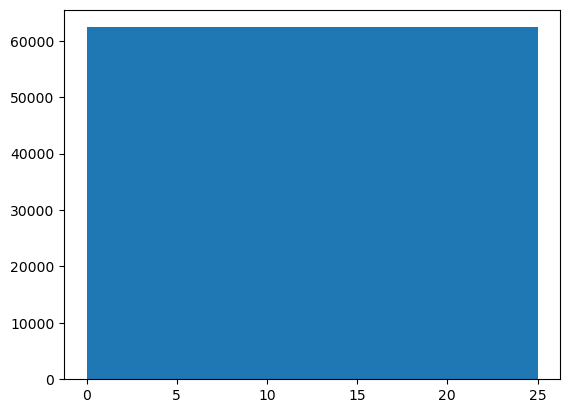

In [74]:
# distribución de clases
plt.hist(y_train, bins=2)
plt.show()
# todo esta parejo y bien distribuido por lo tanto tendremos un entrenamiento balanceado

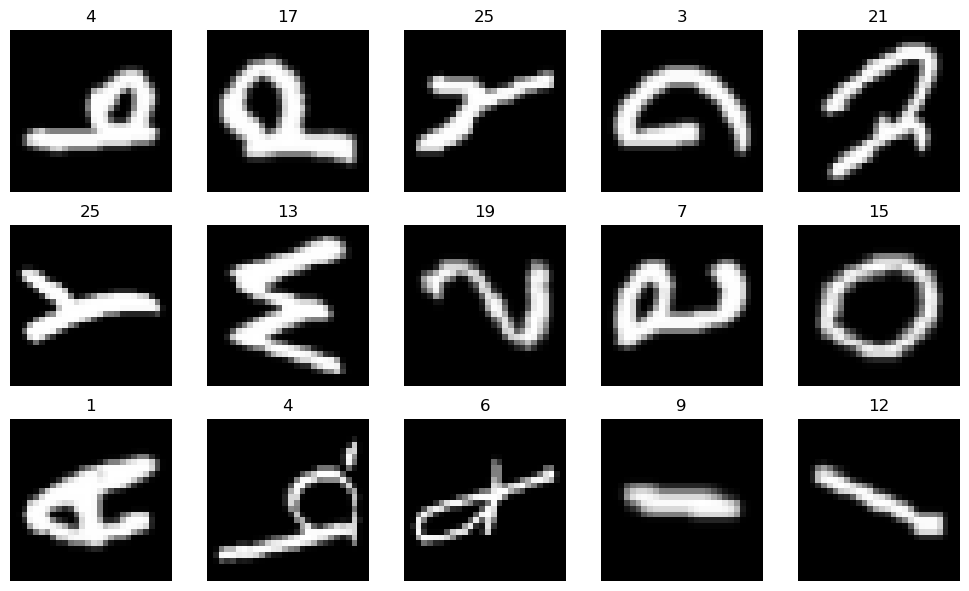

In [75]:
# grafica de imagenes de entrenamiento para hacernos una idea de los datos
r, c = 3, 5 # filas, columnas
fig = plt.figure(figsize=(2*c, 2*r)) # tamaño de la figura
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

In [76]:
# normalizamos las caracteristicas
X_train /= 255.0
X_test /= 255.0

In [77]:
# mostramos las clases
print('y_train clases: ', np.unique(y_train))
print('y_test clases: ', np.unique(y_test))

y_train clases:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
y_test clases:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [78]:
# función de activación softmax y función de pérdida cross-entropy
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True) # type: ignore
    
def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1)) # type: ignore
    loss = loss.mean()
    return loss

In [79]:
# Parámetros de la red neuronal
D_in, H, D_out = 784, 100, 26

# pesos del MLP (copiamos en gpu)
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H)),
          size = (D_in, H)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H, requires_grad=True, device="cuda", dtype=torch.float)

w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(H+H)),
          size = (H, H)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(H, requires_grad=True, device="cuda", dtype=torch.float)

w3 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(H+H)),
          size = (H, H)), requires_grad=True, device="cuda", dtype=torch.float)
b3 = torch.zeros(H, requires_grad=True, device="cuda", dtype=torch.float)

w4 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(H+H)),
          size = (H, H)), requires_grad=True, device="cuda", dtype=torch.float)
b4 = torch.zeros(H, requires_grad=True, device="cuda", dtype=torch.float)

w5 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_out+H)),
          size = (H, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b5 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)

# Convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

# Entrenamiento
epochs = 1000 
lr = 0.7
log_each = 10
l = []

for e in range(1, epochs + 1):
    # forward
    h = X_t.mm(w1) + b1
    h_relu = h.clamp(min=0)  # relu
    h2 = h_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)  # relu
    h3 = h2_relu.mm(w3) + b3
    h3_relu = h3.clamp(min=0)  # relu
    h4 = h3_relu.mm(w4) + b4
    h4_relu = h4.clamp(min=0)  # relu
    y_pred = h4_relu.mm(w5) + b5

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop
    loss.backward()

    with torch.no_grad():
        # update weights
        w1 -= lr * w1.grad  # type: ignore
        b1 -= lr * b1.grad  # type: ignore
        w2 -= lr * w2.grad  # type: ignore
        b2 -= lr * b2.grad  # type: ignore
        w3 -= lr * w3.grad  # type: ignore
        b3 -= lr * b3.grad  # type: ignore
        w4 -= lr * w4.grad  # type: ignore
        b4 -= lr * b4.grad  # type: ignore
        w5 -= lr * w5.grad  # type: ignore
        b5 -= lr * b5.grad  # type: ignore

        # zero out gradients for the next iteration
        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
        w4.grad.zero_()
        w5.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()
        b4.grad.zero_()
        b5.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss: {np.mean(l):.5f}")
    # limpiamos la memoria de la gpu
    torch.cuda.empty_cache()

Epoch 10/1000 Loss: 3.53661
Epoch 20/1000 Loss: 3.36364
Epoch 30/1000 Loss: 3.52164
Epoch 40/1000 Loss: 3.45148
Epoch 50/1000 Loss: 3.39220
Epoch 60/1000 Loss: 3.33450
Epoch 70/1000 Loss: 3.28411
Epoch 80/1000 Loss: 3.25458
Epoch 90/1000 Loss: 3.21172
Epoch 100/1000 Loss: 3.16022
Epoch 110/1000 Loss: 3.14427
Epoch 120/1000 Loss: 3.10214
Epoch 130/1000 Loss: 3.06726
Epoch 140/1000 Loss: 3.02721
Epoch 150/1000 Loss: 2.99622
Epoch 160/1000 Loss: 2.95922
Epoch 170/1000 Loss: 2.91592
Epoch 180/1000 Loss: 2.87229
Epoch 190/1000 Loss: 2.82969
Epoch 200/1000 Loss: 2.78631
Epoch 210/1000 Loss: 2.73844
Epoch 220/1000 Loss: 2.69465
Epoch 230/1000 Loss: 2.64728
Epoch 240/1000 Loss: 2.60527
Epoch 250/1000 Loss: 2.55981
Epoch 260/1000 Loss: 2.51547
Epoch 270/1000 Loss: 2.47198
Epoch 280/1000 Loss: 2.43154
Epoch 290/1000 Loss: 2.39366
Epoch 300/1000 Loss: 2.35595
Epoch 310/1000 Loss: 2.31752
Epoch 320/1000 Loss: 2.28164
Epoch 330/1000 Loss: 2.24706
Epoch 340/1000 Loss: 2.21220
Epoch 350/1000 Loss: 2.

In [86]:
# Definición de la función evaluate para el modelo MLP de 5 capas
def evaluate(x):
    h = x.mm(w1) + b1
    h_relu = h.clamp(min=0)
    h2 = h_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)
    h3 = h2_relu.mm(w3) + b3
    h3_relu = h3.clamp(min=0)
    h4 = h3_relu.mm(w4) + b4
    h4_relu = h4.clamp(min=0)
    y_pred = h4_relu.mm(w5) + b5
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)  # type: ignore

In [87]:
# importamps sklearn para usar accuracy_score
from sklearn.metrics import accuracy_score

# prediciendo el conjunto de test
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.8505769230769231

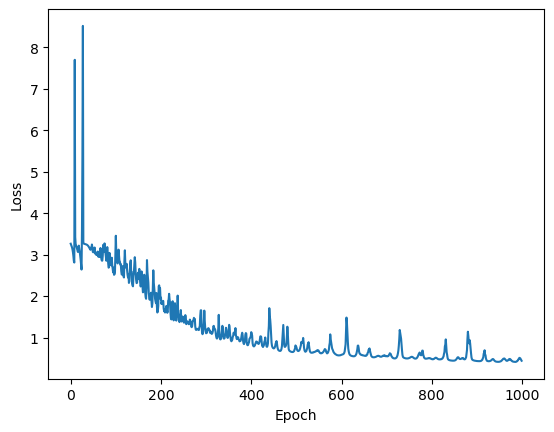

In [88]:
# graficar la loss
plt.plot(l)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

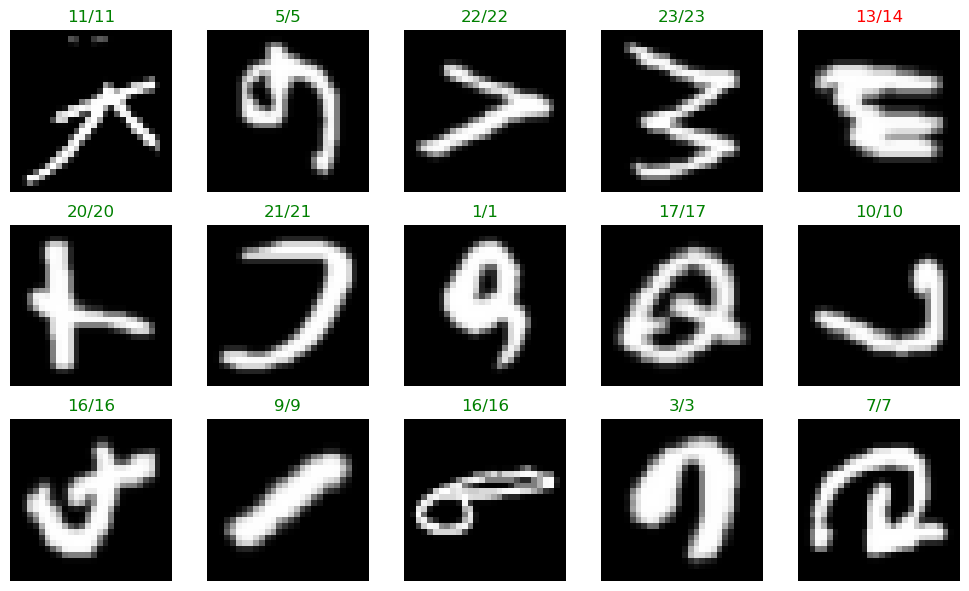

In [92]:
# graficamos 15 ejemplos de test
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()